In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 256

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [3]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [4]:
%load_ext autoreload
%autoreload 2

In [4]:
import torch.optim as optim
from el2n import EL2NMetric

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = Net()
metric = EL2NMetric(model, 5, device)

In [5]:
metric.train(trainloader, 5)

Epoch 0



100%|██████████| 196/196 [00:08<00:00, 23.32it/s]


Epoch 1



100%|██████████| 196/196 [00:06<00:00, 30.36it/s]


Epoch 2



100%|██████████| 196/196 [00:06<00:00, 28.47it/s]


Epoch 3



100%|██████████| 196/196 [00:06<00:00, 30.50it/s]


Epoch 4



100%|██████████| 196/196 [00:06<00:00, 29.73it/s]


In [6]:
indices, metrics = metric.get_metric(testset)

print(indices.size(), metrics.size())

torch.Size([10000]) torch.Size([10000])


In [8]:
from data_utils import get_subset_random_sampler

In [9]:
sampler = get_subset_random_sampler(indices, metrics, 0.5)

In [10]:
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2, sampler=sampler)

In [11]:
s = 0
for x, y in testloader:
    s += x.size(0)
print(s)

5000


In [3]:
import pickle
metrics_filename = f'./results/metrics_cifar10_el2n.pkl'
with open(metrics_filename, 'rb') as f:
    indices, metrics = pickle.load(f)

Images with the lowest VoG scores:


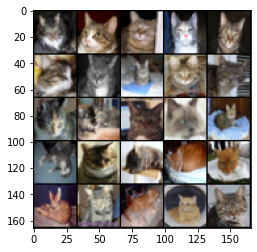

Images with the highest VoG scores:


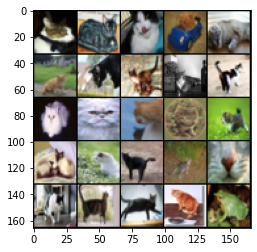

In [9]:
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt

def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
def select_images_by_class(dataset, target_class):
    selected_images = []
    selected_labels = []

    for i in range(len(dataset)):
        image, label = dataset[i]
        if label == target_class:
            selected_images.append(image)
            selected_labels.append(label)

    return selected_images, selected_labels

def plot_extreme_vog_images(testset, indices, vog_scores, target_class, num_images=25):
    # Sort images by VoG scores
    sorted_indices = np.argsort(vog_scores)
    
    # Filter sorted_indices to only include indices of images that belong to the target class
    sorted_indices = [i for i in sorted_indices if testset[i][1] == target_class]
    
    # Select the top and bottom images
    lowest_vog_indices = sorted_indices[:num_images]
    highest_vog_indices = sorted_indices[-num_images:]
    
    # Create a dataset with the selected images
    lowest_vog_images = torch.stack([testset[i][0] for i in lowest_vog_indices])
    highest_vog_images = torch.stack([testset[i][0] for i in highest_vog_indices])

    # Plot the images with the lowest VoG scores
    print("Images with the lowest VoG scores:")
    imshow(vutils.make_grid(lowest_vog_images, nrow=num_images // 5, padding=1, normalize=True))

    # Plot the images with the highest VoG scores
    print("Images with the highest VoG scores:")
    imshow(vutils.make_grid(highest_vog_images, nrow=num_images // 5, padding=1, normalize=True))

# Visualize the 25 images with the lowest and highest VoG scores
plot_extreme_vog_images(testset, indices.detach().cpu(), metrics.detach().cpu(), 3)
